In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numpy import log10

Parâmetros

In [62]:
#controlador = "PID"
alfa = 0.01               # horas

#cinética (saccharomyces)
mumax = 0.4               # 1/horas
Ks = 5                    # g/L
pH_ideal = 4.25
pH_ideal_range = 4.5 - 4

#Fatores de conversão
Yxs = 0.03                # g/g
Ypx = 0.4/Yxs             # g/g
Yhx = 0.7                 # mol/g

#alimentação - substrato
Fs = 1                    # L/horas
Sf = 0.015                # g/L

#alimentação - base
FoH = 1                   # L/horas
oHf = 10**(-1)            # moles/L

#condições iniciais
Xi = 0.015                # g/L
Pi = 0                    # g/L
Si = 0.005                # g/L
Vi = 190*1000             # L
pHi = 4

s1_0 = FoH
s2_0 = 0

#tempo (residência)
t_final = 68            # horas

Funções, Controlador, Modelo e Simulador

In [73]:
# taxas de reação (Monod)
def mu_pH(H):
    return np.exp(-((pH_ideal - (-log10(H))) / pH_ideal_range)**2)
def mu(S,H):
    return mumax*S/(Ks + S)*mu_pH(H)
def Rg(X,S,H):
    return mu(S,H)*X
def Rp(X,S,H):
    return Rg(X,S,H)*Ypx
def Rh(X,S,H):
    return Rg(X,S,H)*Yhx

# modelo
def modelo(t, y, controlador):
    X, P, S, V, H, s1, s2 = y

    match controlador:
        case "off":
            ds1 = 0
            ds2 = 0
            B = 0
        case "step":
            ds1 = 0
            ds2 = 0
            B = FoH
        case "PID":
            ds1 = pH_ideal - (-log10(H))
            ds2 = -1 / (alfa * Kd) * s2 + ds1 / (alfa * Kd)
            B = max(0, Kp / Ki * s1 - Kp / alfa * s2 + Kp * (1 / alfa + 1) * ds1)
        case "n-linear":
            #WIP
            ds1 = 0
            ds2 = 0
            B = 0
        case _:
            ds1 = 0
            ds2 = 0
            B = 0

    dV = Fs + B
    dX = Rg(X,S,H) - dV*X/V
    dP = Rp(X,S,H) - dV*P/V
    dS = dV*(Sf - S)/V - Rg(X,S,H)/Yxs
    dH = max(10**(-14),Rh(X, S, H) - B*oHf/V - dV*H/V)

    return [dX, dP, dS, dV, dH, ds1, ds2]

def simulacao(t, controlador):
    IC = [Xi, Pi, Si, Vi, 10**(-pHi), s1_0, s2_0]
    options = {
        'method': 'BDF',
        'rtol': 1e-6, 'atol': 1e-8
    }
    simulacao = solve_ivp(modelo, [0, t], IC, t_eval=np.linspace(0, t, 1000), args=(controlador,), **options)

    df = pd.DataFrame(simulacao.y.T, columns=["X", "P", "S", "V", "H", "s1", "s2"])
    df["pH"] = -log10(df["H"])
    df["Tempo"] = simulacao.t

    return df

def simulacao_EE(controlador, tol=1e-3, max_iter=10000):
    IC = [Xi, Pi, Si, Vi, 10**(-pHi), s1_0, s2_0]
    t_atual = 0
    t_step = 1.0
    resultados = []
    variaveis_anteriores = IC

    for i in range(max_iter):
        sol = solve_ivp(modelo, [t_atual, t_atual + t_step], variaveis_anteriores, args=(controlador,), method='BDF', rtol=1e-6, atol=1e-8)
        variaveis_atuais = sol.y[:, -1]
        resultados.append(variaveis_atuais)
        t_atual += t_step

        # Verificar se o estado estacionário foi atingido
        delta = np.max(np.abs((variaveis_atuais - variaveis_anteriores) / (np.array(variaveis_anteriores) + 1e-10)))
        if delta < tol:
            break

        variaveis_anteriores = variaveis_atuais

    resultados = np.array(resultados).T
    df = pd.DataFrame(resultados.T, columns=["X", "P", "S", "V", "H", "s1", "s2"])
    df["pH"] = -log10(df["H"])
    df["Tempo"] = np.linspace(0, t_atual, len(df))

    return df

def graficos(df):
    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    # Gráfico 1: X, P, S em função do tempo
    df.plot(
        x="Tempo",
        y=["X", "P", "S"],
        ylim = (0, 0.02),
        xlim = (0, t_final),
        grid=True,
        ax=ax[0],
        #title="X, P e S",
        xlabel="Horas",
        ylabel="g / L"
    )
    '''
    # Gráfico 2: V em função do tempo
    df.plot(
        x="Tempo",
        y="V",
        grid=True,
        ax=ax[1],
        #title="Volume",
        xlabel="Horas",
        ylabel="L"
    )
    '''
    # Gráfico 3: pH em função do tempo
    df.plot(
        x="Tempo",
        y="pH",
        ylim = (3,5),
        xlim = (0,t_final),
        grid=True,
        ax=ax[1],
        #title="pH",
        xlabel="Horas",
        ylabel="pH"
    )

    plt.tight_layout()
    plt.show()

def otimizacao_IMC():
    con = 'step'
    df = simulacao_EE(controlador=con) # simulação até o estado estacionário com critério de convergência

    delta_y = df['pH'].iloc[-1] - df['pH'].iloc[0] #ultima medida de pH menos primeira medida de pH
    delta_u = FoH - 0 #tamnaho step

    pH_353 = df['pH'].iloc[0] + 0.353*delta_y # pH a 35,3 % dp EE
    t_353 = df.loc[(df['pH'] - pH_353).abs().idxmin(), 'Tempo'] #tempo nessa estágio

    pH_853 = df['pH'].iloc[0] + 0.853*delta_y # pH a 85,3 % dp EE
    t_853 = df.loc[(df['pH'] - pH_853).abs().idxmin(), 'Tempo'] #tempo nesse estágio

    K = delta_y/delta_u
    tau = 0.67*(t_853 - t_353)
    tau_c = tau/2

    Kp_o = float((2*tau + alfa)/(2*K*(tau_c + alfa)))
    Ki_o = float(tau + (alfa/2))
    Kd_o = float(tau*alfa/(2*tau + alfa))

    return [Kp_o,Ki_o,Kd_o]

Simulacao sem controle (sem fluxo de base)

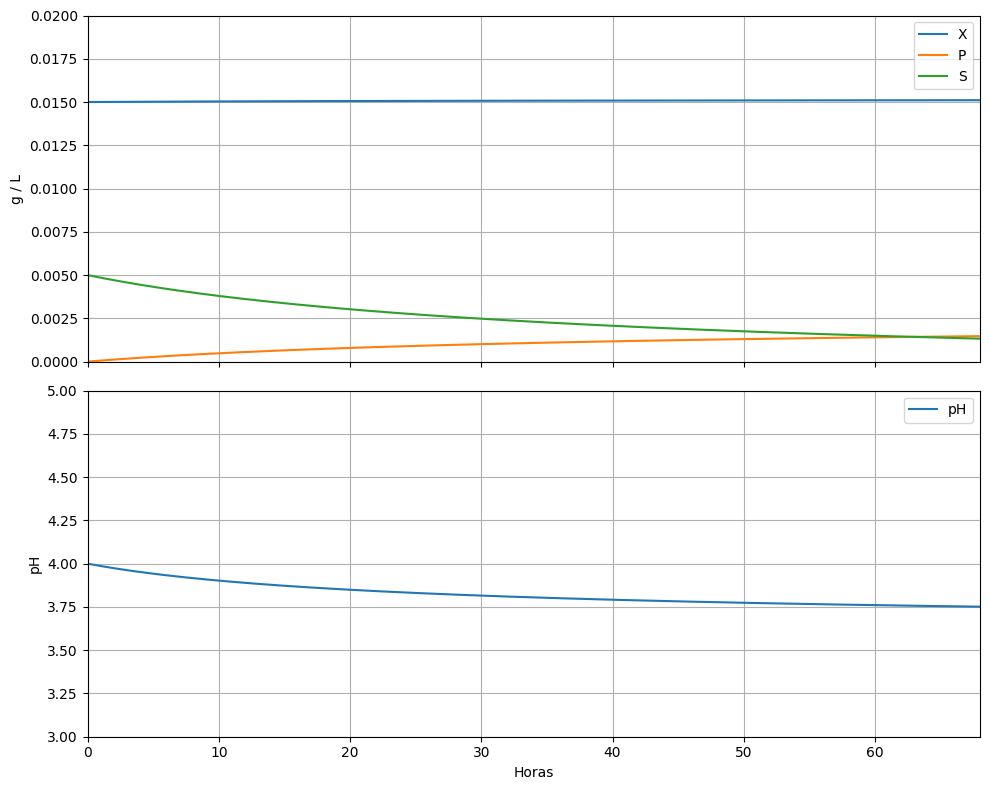

In [74]:
sim_1 = simulacao(t_final, 'off')
graficos(sim_1)

Simulação estado estacionário (com step)

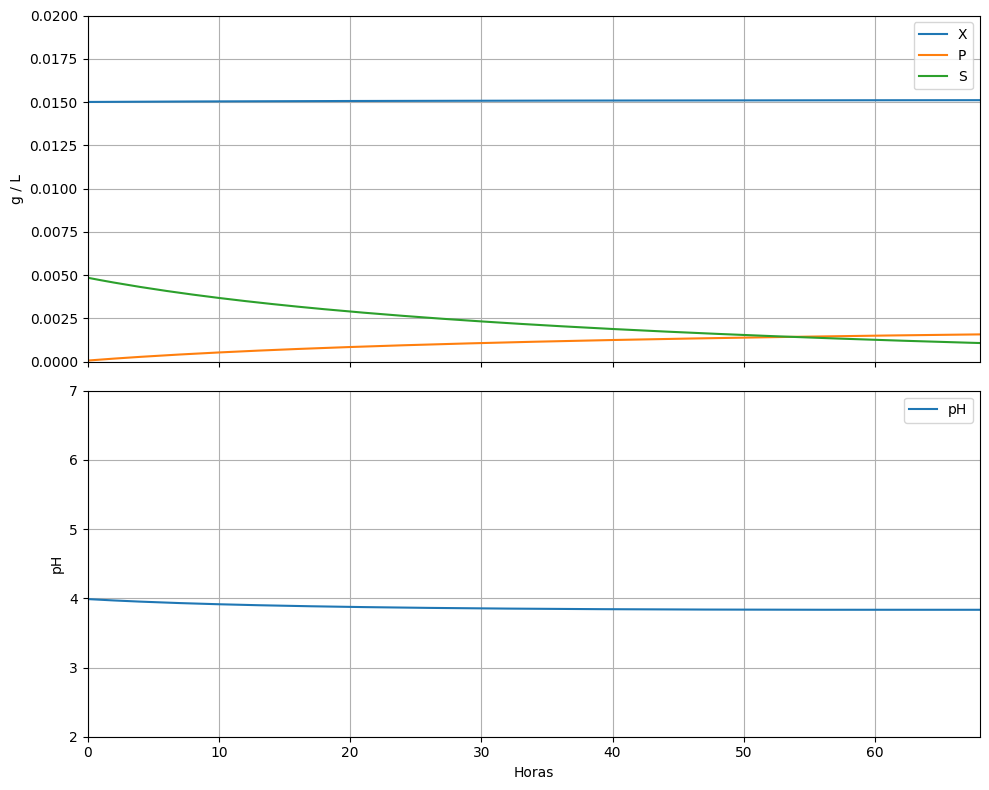

In [64]:
sim_2 = simulacao_EE('step')
graficos(sim_2)

simulacao com PID

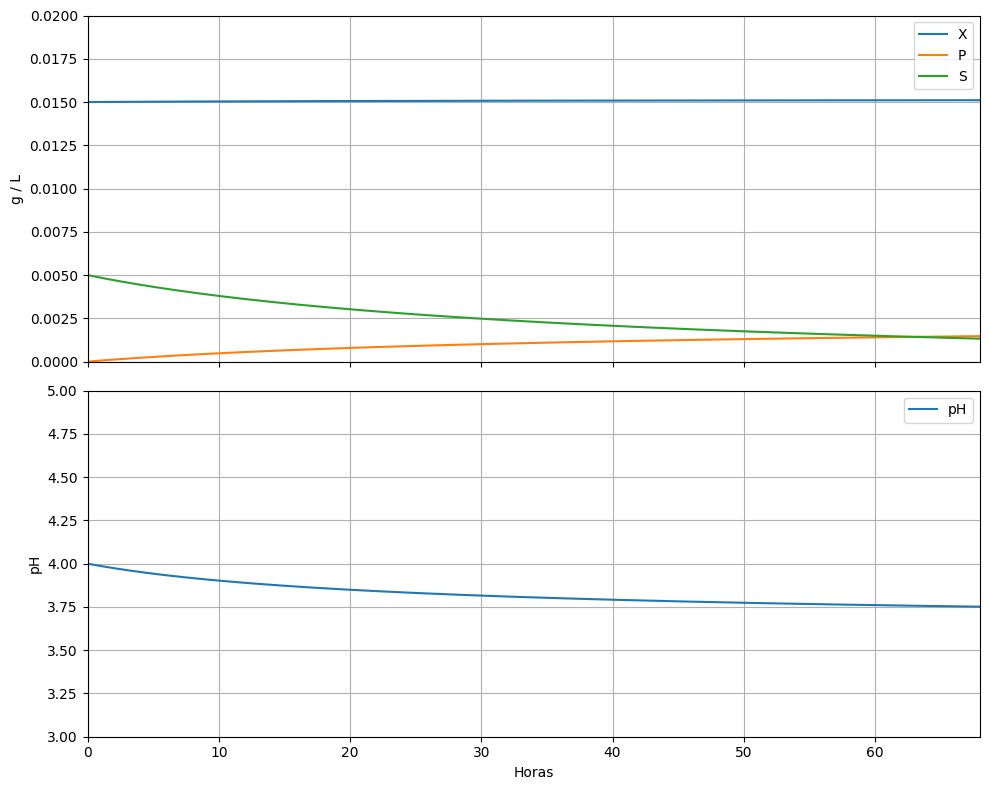

In [70]:
vetor_K = otimizacao_IMC()
Kp = vetor_K[0]
Ki = vetor_K[1]
Kd = vetor_K[2]

#Kp = 10
#Ki = 1
#Kd = 1

sim_PID = simulacao(t_final, 'PID')
graficos(sim_PID)